Following http://alimanfoo.github.io/2015/09/28/fast-pca.html in this notebook

In [1]:
#Initial configuration, probably overkill in imports.
import sys, os, re
import numpy as np
import allel
import zarr
import dask
import numcodecs
import warnings
from pathlib import Path

#os.environ["MODIN_ENGINE"] = "ray"

#import modin.pandas as pd
import pandas as pd

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
sns.set_theme()
sns.set_style("white")
sns.set_context("notebook")

In [2]:
#
meta_data_samples = pd.read_table("../data/meta_data_samples.txt", sep = " ")
meta_data_samples

,Unnamed: 0,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index
0,1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,0
1,2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,1
2,3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,2
3,4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,3
4,5,PD_0203,21SNF1151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,4
...,...,...,...,...,...,...,...,...,...,...,...,...
155,212,PD_0789,34417_BZ11064,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,155
156,213,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,156
157,214,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,157
158,215,PD_0792,34420_BZ11067,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,158


In [3]:
#Opening the zarr data
callset = zarr.open_group('/faststorage/project/primatediversity/people/kmt/baboon_flagship/steps/callset.zarr', mode='r')
callset.tree(expand=False)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='chr1', nodes=(Node(disabled=True, n…

In [4]:
chrom_pca = "chrX"
gt_zarr = allel.GenotypeChunkedArray(callset["{}/calldata/GT".format(chrom_pca)])
gt_zarr

<GenotypeChunkedArray shape=(3609325, 160, 2) dtype=int8 chunks=(65536, 64, 2)
   nbytes=1.1G cbytes=258.9M cratio=4.3
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [5]:
ac = gt_zarr.count_alleles()[:]
ac

<AlleleCountsArray shape=(3609325, 5) dtype=int32>
 5  3  0  0  0
18  2  0  0  0
69  1  0  0  0
...
39  1  0  0  0
19  1  0  0  0
11  1  0  0  0

In [6]:
np.count_nonzero(ac.max_allele() > 1)

37616

In [7]:
np.count_nonzero((ac.max_allele() == 1) & ac.is_singleton(1))

314431

In [8]:
#Filter, keeping only biallelic snps which are not singletons.
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = gt_zarr.compress(flt, axis=0)
gf

<GenotypeChunkedArray shape=(2359630, 160, 2) dtype=int8 chunks=(4609, 160, 2)
   nbytes=720.1M cbytes=174.6M cratio=4.1
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [9]:
gn = gf.to_n_alt()
gn

<ChunkedArrayWrapper shape=(2359630, 160) dtype=int8 chunks=(9218, 160)
   nbytes=360.1M cbytes=68.9M cratio=5.2
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [10]:
#Updated a few of the calls to allel so it works.
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

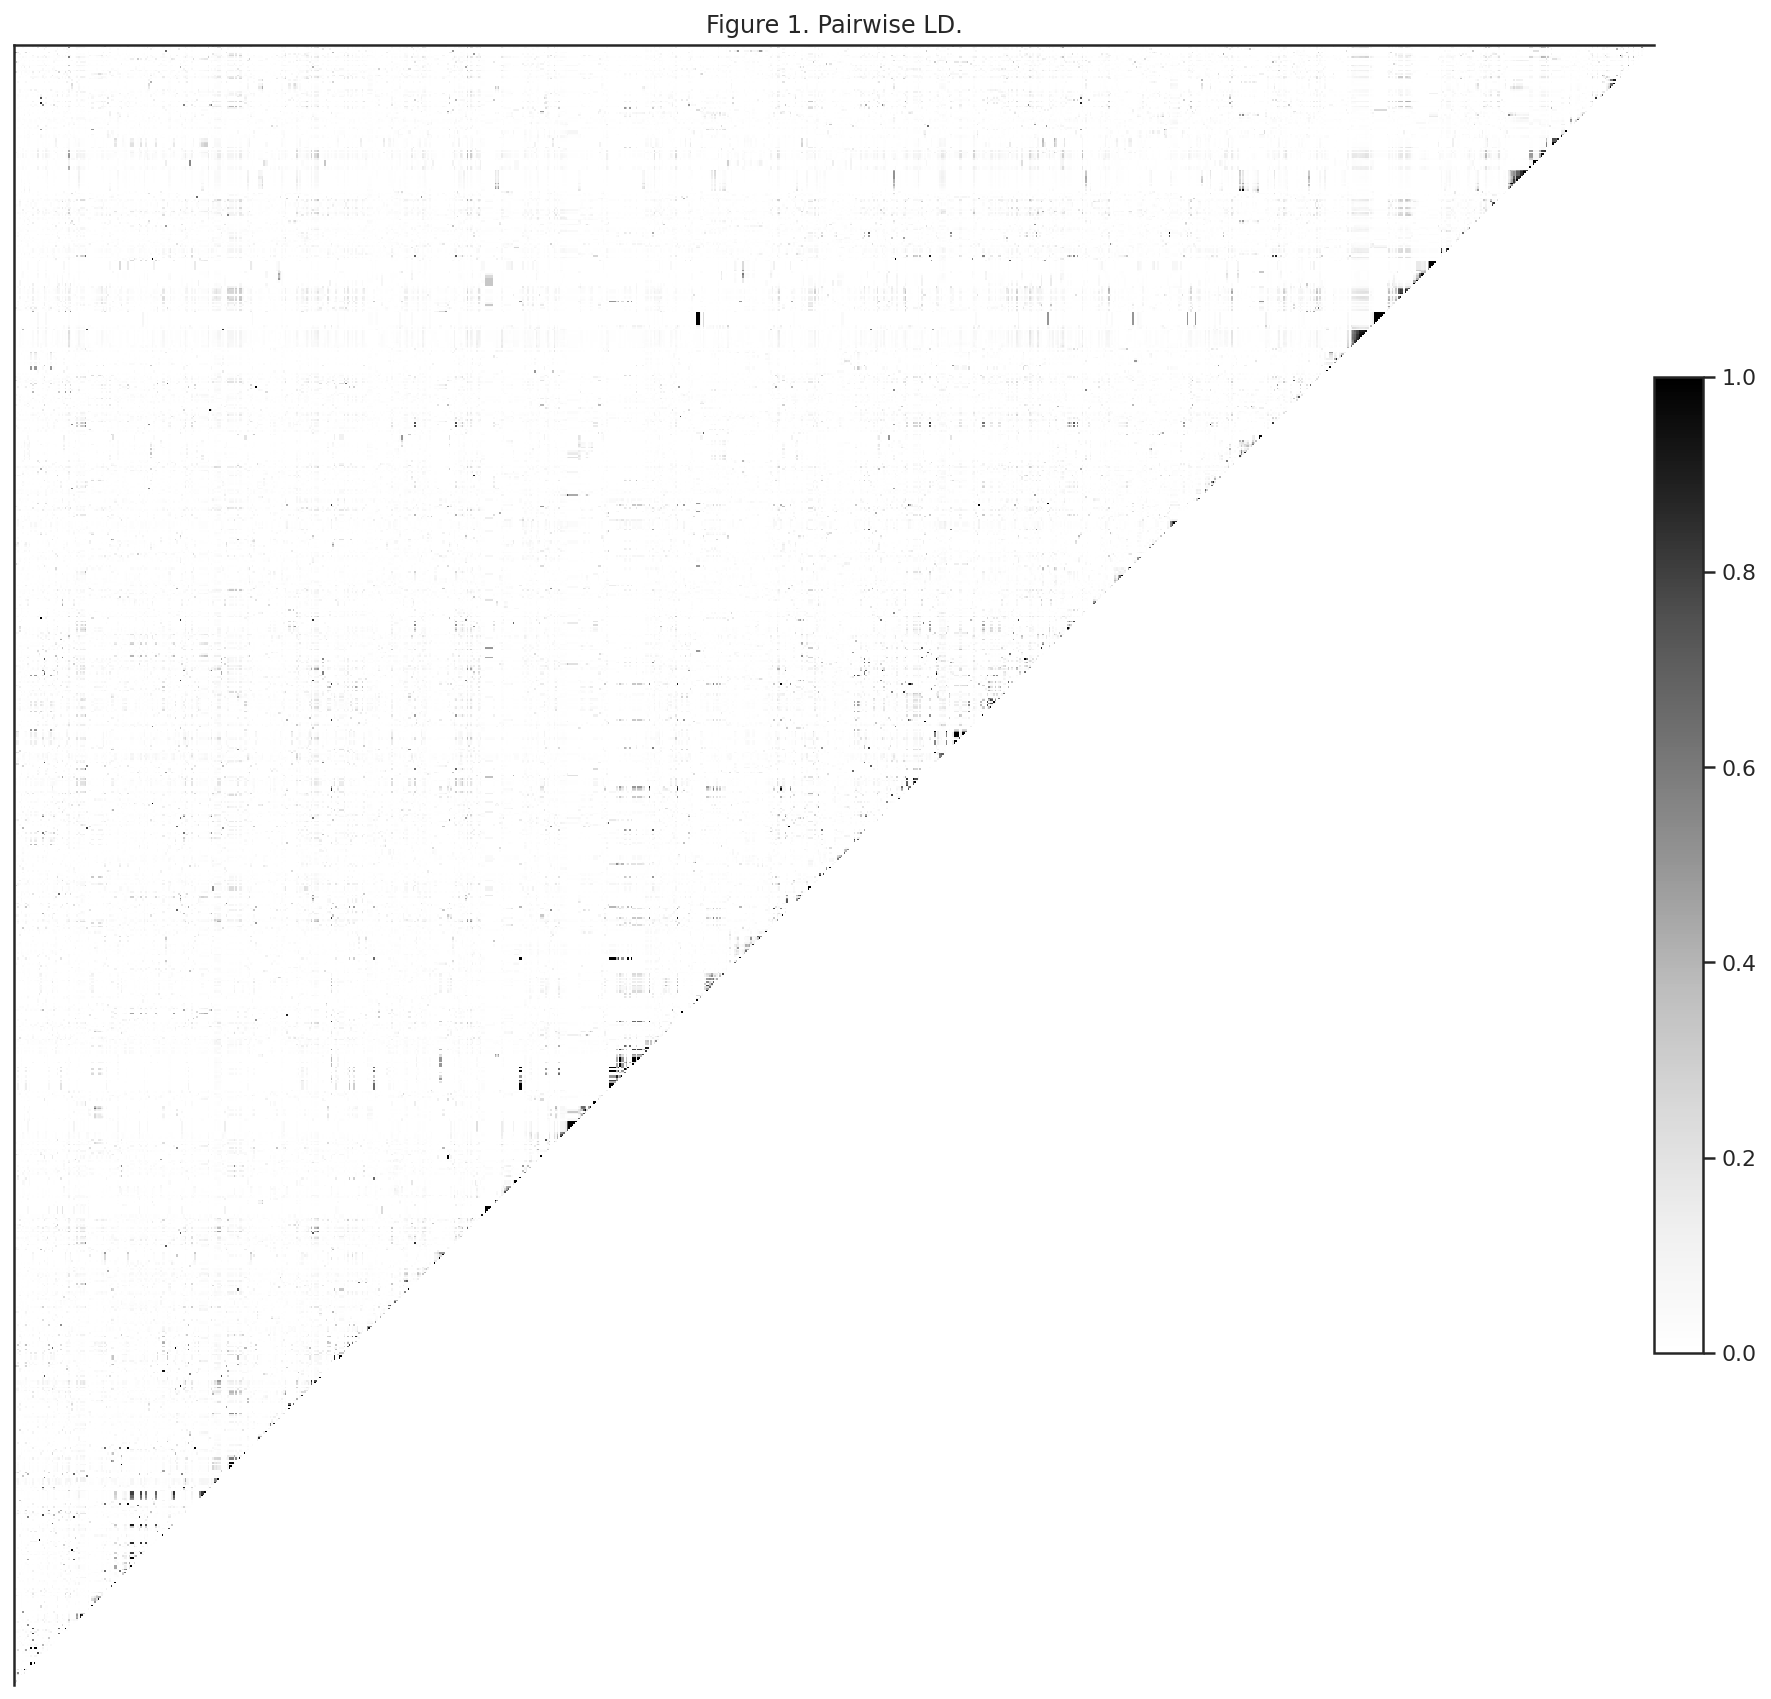

In [11]:
plot_ld(gn[:1000], 'Figure 1. Pairwise LD.') #LD is less extreme than in the tutorial

In [12]:
#First, random downsampling
n = 1000000  # number of SNPs to choose randomly
vidx = np.random.choice(gn.shape[0], n, replace=False)
vidx.sort()
gnr = gn.take(vidx, axis=0)
gnr

<ChunkedArrayWrapper shape=(1000000, 160) dtype=int8 chunks=(7813, 160)
   nbytes=152.6M cbytes=30.0M cratio=5.1
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

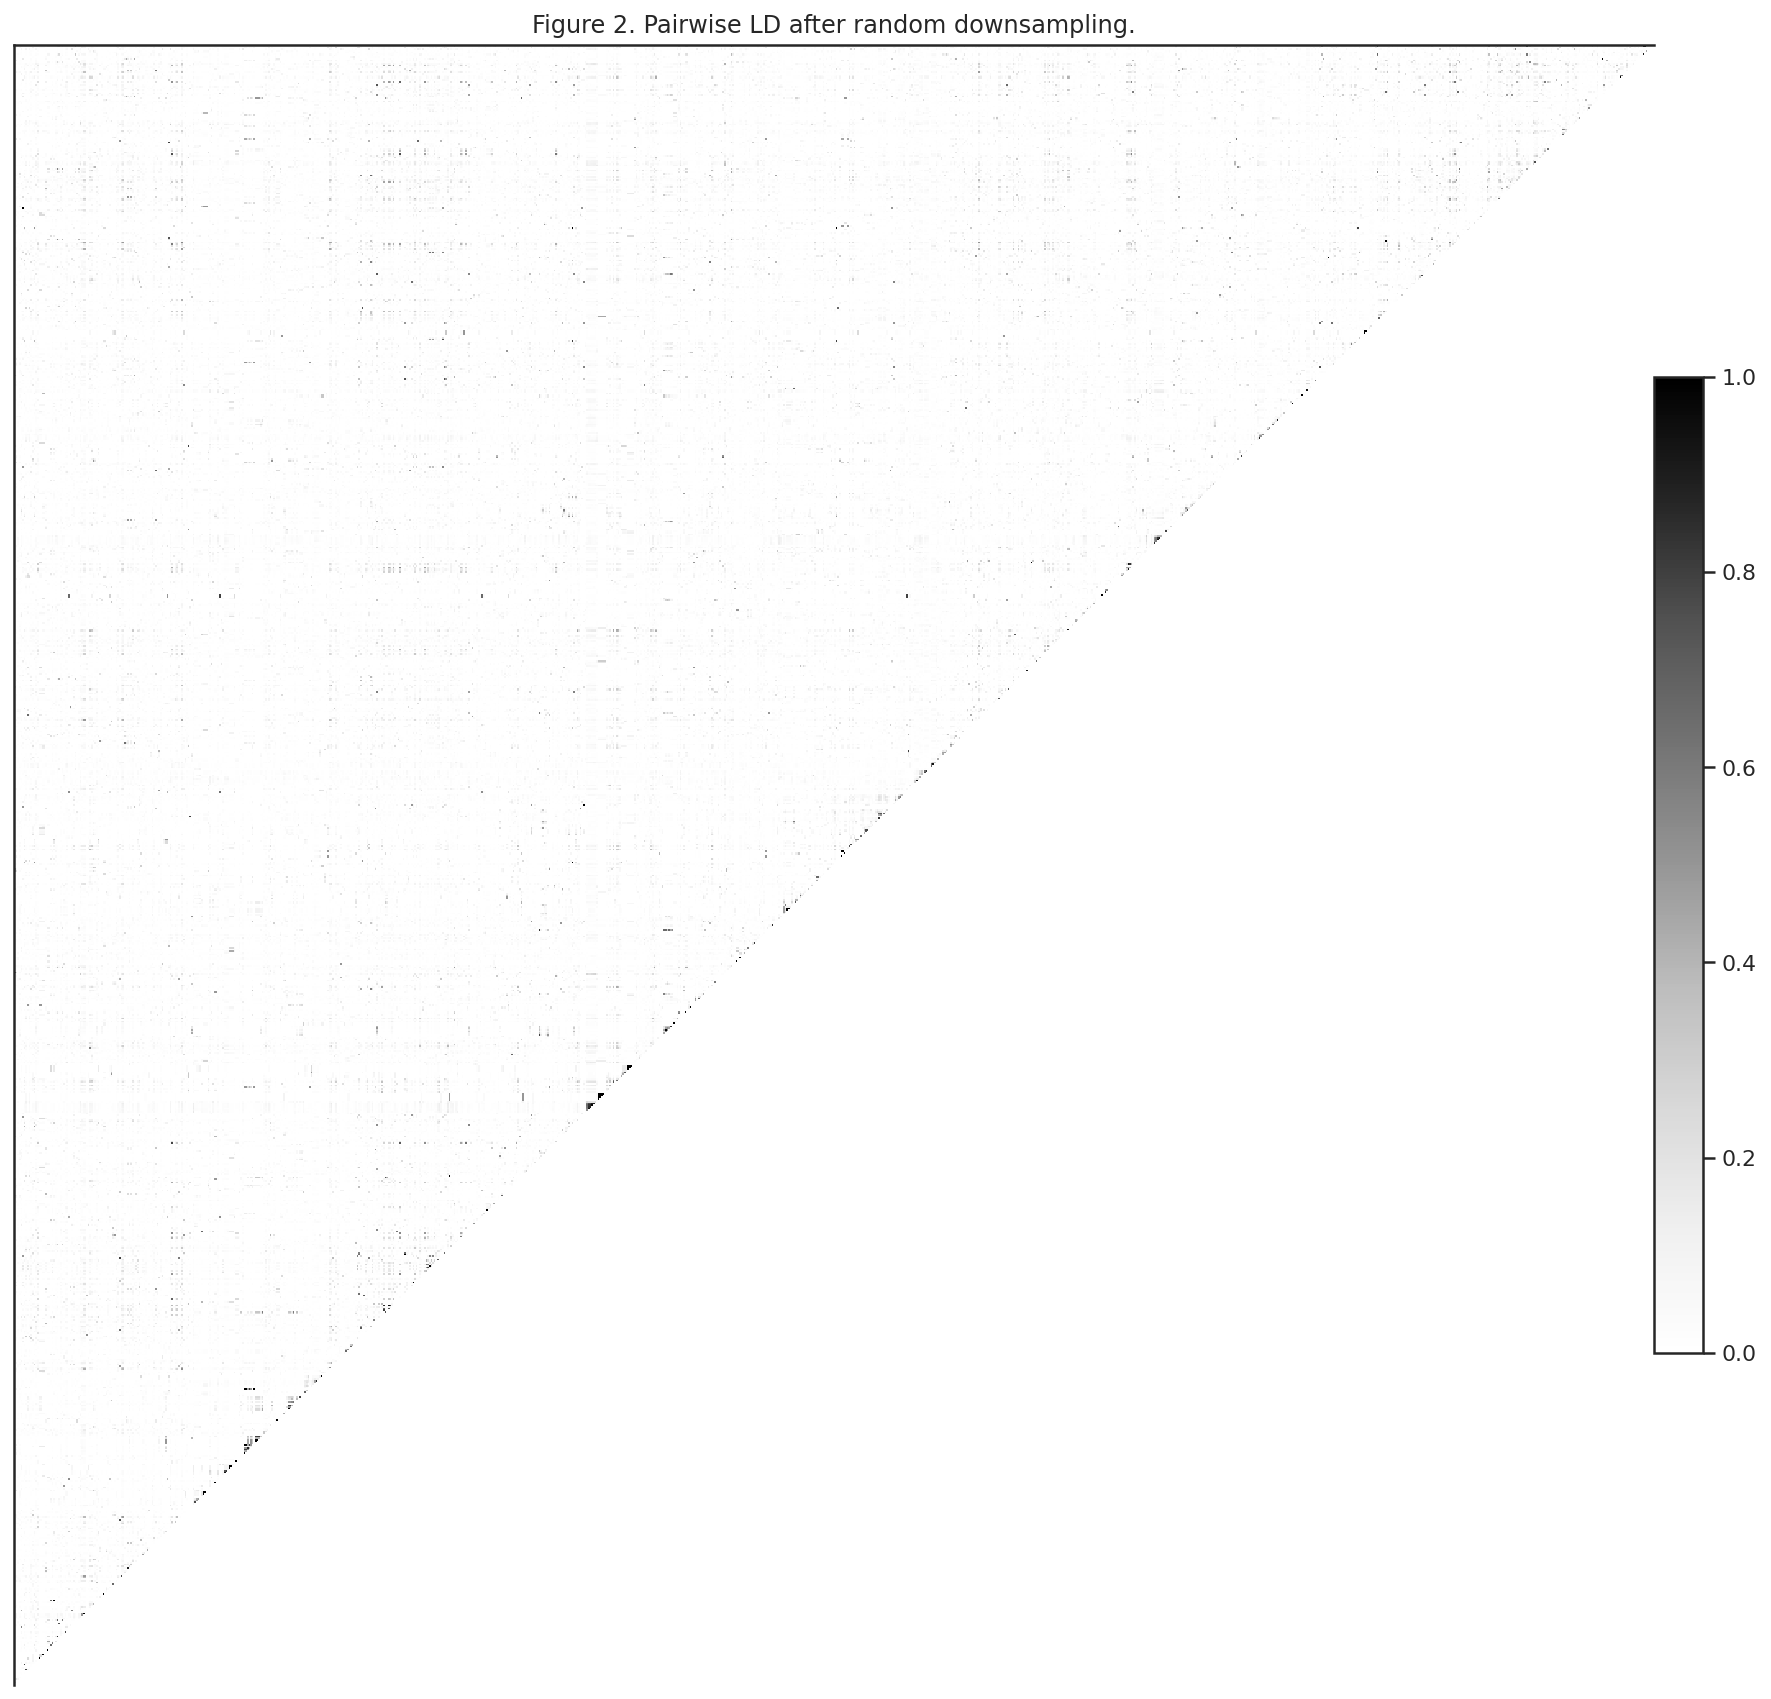

In [13]:
plot_ld(gnr[:1000], 'Figure 2. Pairwise LD after random downsampling.')

In [14]:
#LD pruning
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [15]:
gnu = ld_prune(gnr, size=500, step=200, threshold=.1, n_iter=5)

iteration 1 retaining 160919 removing 839081 variants
iteration 2 retaining 58250 removing 102669 variants
iteration 3 retaining 32518 removing 25732 variants
iteration 4 retaining 23508 removing 9010 variants
iteration 5 retaining 19614 removing 3894 variants


In [16]:
#Trying an even larger window, and without random downsampling
gnr = gn
gnu = ld_prune(gnr, size=1000, step=200, threshold=.1, n_iter=5)

iteration 1 retaining 229151 removing 2130479 variants
iteration 2 retaining 63351 removing 165800 variants
iteration 3 retaining 32121 removing 31230 variants
iteration 4 retaining 22831 removing 9290 variants
iteration 5 retaining 19261 removing 3570 variants


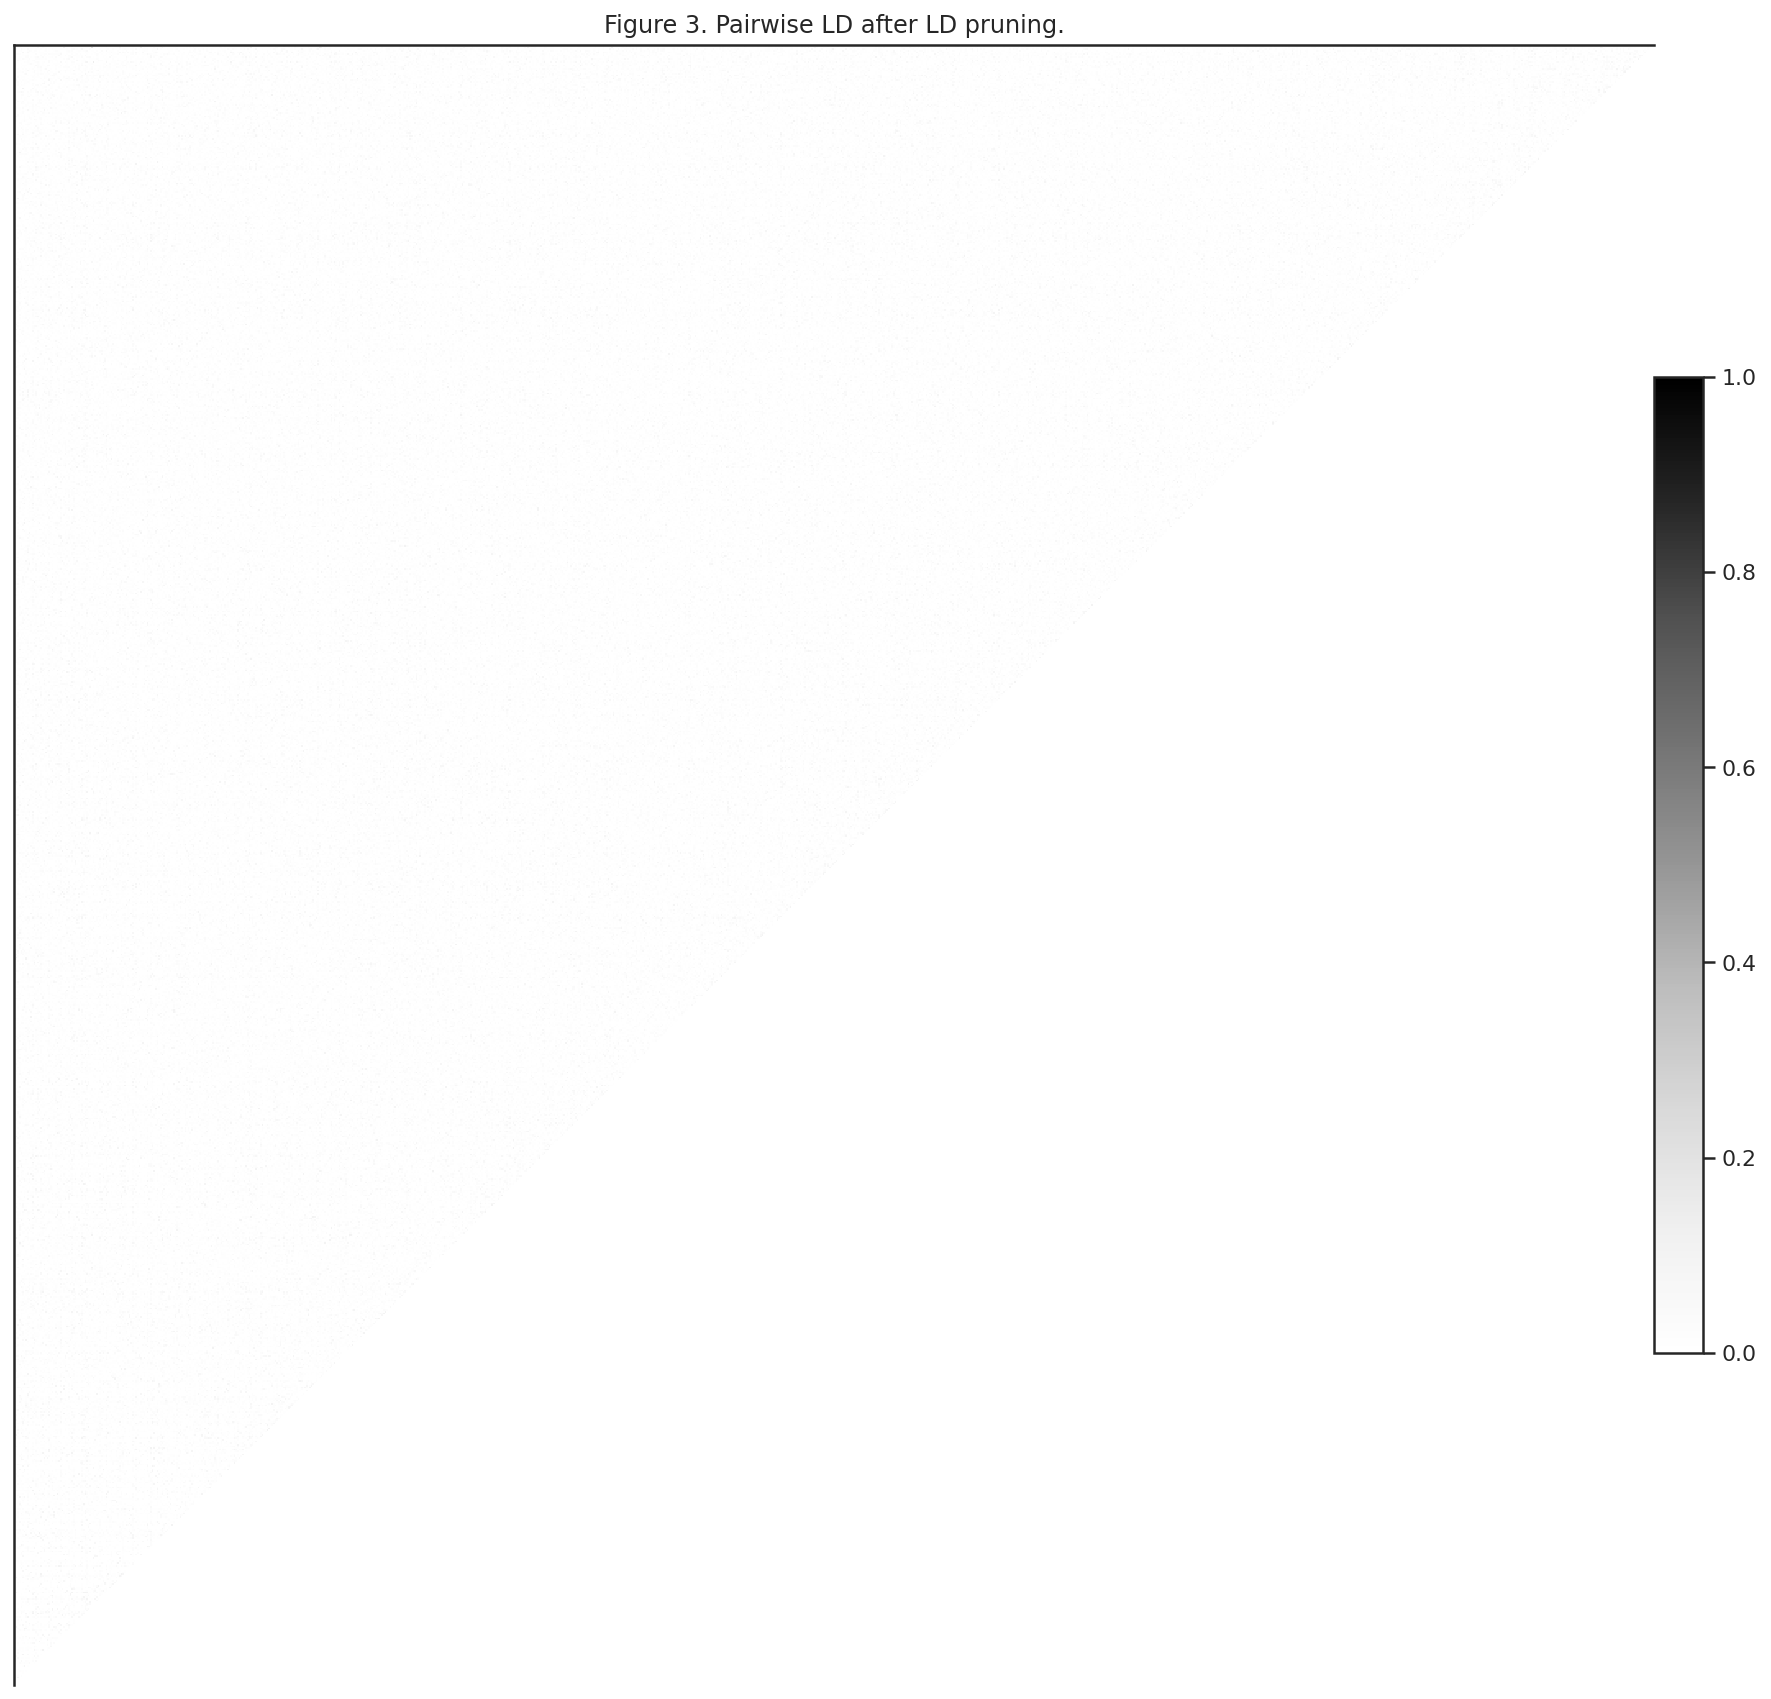

In [17]:
plot_ld(gnu[:1000], 'Figure 3. Pairwise LD after LD pruning.')

In [18]:
#Out of chunked storage
gnu = gnu[:]
gnu

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 2, ..., 2, 2, 0],
       [2, 2, 2, ..., 2, 2, 2],
       [0, 0, 1, ..., 2, 0, 2]], dtype=int8)

In [19]:
coords1, model1 = allel.pca(gnu, n_components=10, scaler='patterson')

In [20]:
#The plotting solution in the example is inflexible, so I will try to make it through seaborn.
pca_df = pd.DataFrame()
c_transposed = coords1.transpose()
for i in range(len(c_transposed)):
    pc = "pc{}".format(i+1)
    pca_df[pc] = c_transposed[i]


In [21]:
pca_df_meta = pd.concat([pca_df, meta_data_samples], axis = 1)

In [30]:
%matplotlib widget

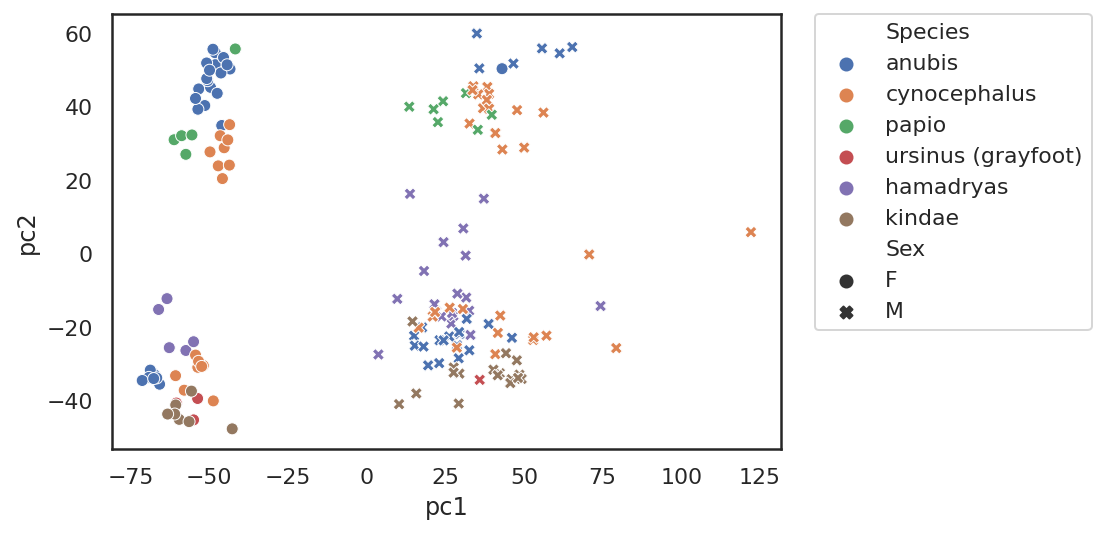

In [22]:
#PC1 is clearly dominated by the signal from males versus females.
#An individual from anubis is probably misgendered.
sns.scatterplot(data = pca_df_meta, x="pc1", y="pc2", hue="Species", style="Sex")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

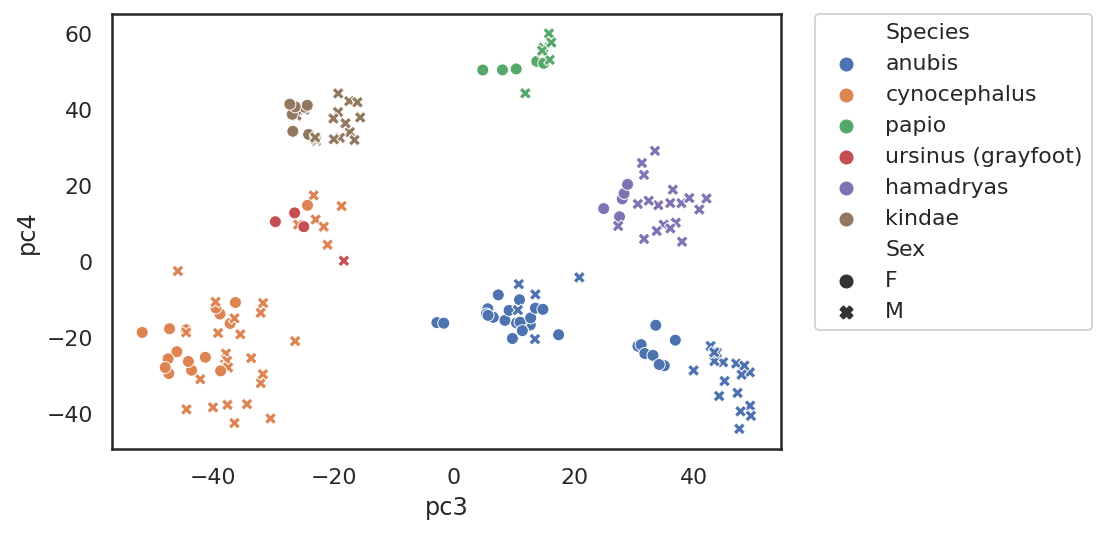

In [23]:
#PC3/4 seems more promising
sns.scatterplot(data = pca_df_meta, x="pc3", y="pc4", hue="Species", style="Sex")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

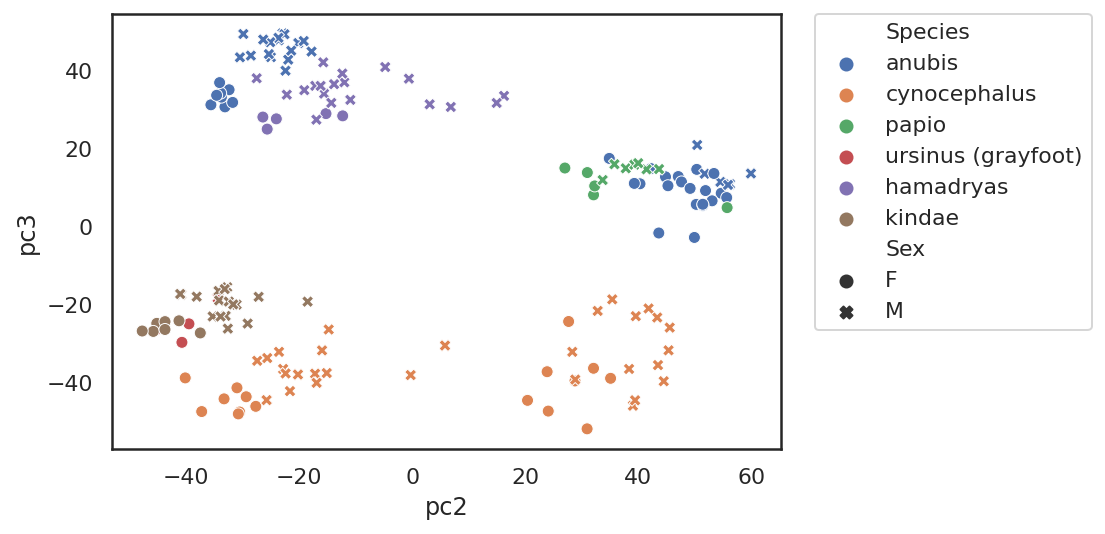

In [24]:
#Lastly, pc2 vs pc3
sns.scatterplot(data = pca_df_meta, x="pc2", y="pc3", hue="Species", style="Sex")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [25]:
#This individual seems to be male, even though it is noted as female.
row = pca_df_meta.loc[(pca_df_meta.pc1 > 0) & (pca_df_meta.Sex == "F")]
row.PGDP_ID

3    PD_0202
Name: PGDP_ID, dtype: object

In [26]:
#Setting up a function to do a PCA for a specific input
def pruning_and_pca(chrom, IDs, subsampling_n, size, n_iter):
    print("Investigating {} with {} individuals".format(chrom, len(IDs)))
    gt_zarr = allel.GenotypeChunkedArray(callset["{}/calldata/GT".format(chrom)]) #Loading in the zarr dataset
    gt_zarr = gt_zarr.take(IDs, axis=1)
    ac = gt_zarr.count_alleles()[:] #Allele counts for each pos
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1) #Filtering for biallelic 
    #and at least two individuals in the alt state
    gf = gt_zarr.compress(flt, axis=0) #Applying filter
    gn = gf.to_n_alt() #Transform genotype to number of non-ref alleles
    vidx = np.random.choice(gn.shape[0], subsampling_n, replace=False) #Random subsampling
    vidx.sort()
    gnr = gn.take(vidx, axis=0) #Applying the random subsample
    gnu = ld_prune(gnr, size=size, step=200, threshold=.1, n_iter=n_iter) #Pruning based on LD
    gnu = gnu[:] #Taking it out of chunked storage
    coords1, model1 = allel.pca(gnu, n_components=10, scaler='patterson') #Running the pca
    #The plotting solution in the example is inflexible, so I will try to make it through seaborn.
    pca_df = pd.DataFrame()
    c_transposed = coords1.transpose()
    for i in range(len(c_transposed)):
        pc = "pc{}".format(i+1)
        pca_df[pc] = c_transposed[i]
    pca_df_meta = pd.concat([pca_df, meta_data_samples.iloc[IDs].reset_index()], axis = 1, ignore_index=False)
    return pca_df_meta

In [27]:
IDs = meta_data_samples.loc[(meta_data_samples.Sex == "F") & (meta_data_samples.PGDP_ID != "PD_0202")].callset_index.values
pca_df = pruning_and_pca("chrX", IDs, 1000000, 500, 2) #Make sure that enough variants are removed.

Investigating chrX with 63 individuals
iteration 1 retaining 67537 removing 932463 variants
iteration 2 retaining 11381 removing 56156 variants


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

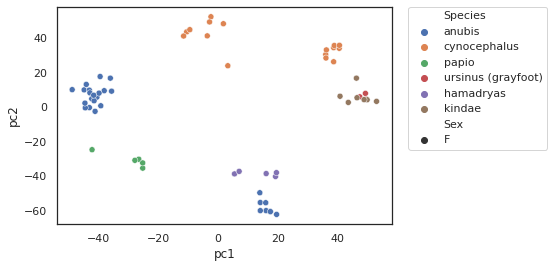

In [32]:
sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Species", style="Sex")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [29]:
#Next time, remove all males and see if that improves the plot
#Also try subsampling so that number of individuals for each species is closer.